# Enhanced CNN-LSTM with Attention Mechanisms

## Novel Architecture for Assignment Evaluation

**Enhancements over Model 3:**
1. **Spatial Attention** - Focuses on important spatial regions (hippocampus, cortex)
2. **Channel Attention (SE-Blocks)** - Emphasizes important feature channels
3. **Residual Connections** - Better gradient flow, prevents degradation

**Expected Improvement:** 97.99% → 98.5-99% accuracy

**Target:** Meet 20% "Novel Architecture" criterion

In [3]:
# Load utilities
%run 00_utils_and_config.ipynb

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Device: cuda
Configuration loaded successfully!

Base path: C:\Users\rishi\CV_Assignment\Paper2
Raw data path: C:\Users\rishi\CV_Assignment\Paper2\Raw_Data
Number of models: 5
Data processing functions loaded successfully!
Evaluation metrics functions loaded successfully!
Visualization functions loaded successfully!
Data augmentation setup loaded successfully!

PAPER 2 UTILITIES AND CONFIGURATION - SUMMARY

✓ All libraries imported successfully
✓ Configuration parameters loaded
✓ Data processing functions defined
✓ Evaluation metrics functions defined
✓ Visualization functions defined
✓ Data augmentation configured

Ready to proceed with:
  - Notebook 01: Data Preparation
  - Notebooks 02-06: Model Implementations
  - Notebook 07: Results Comparison



## 1. Load Data (Same as Model 3)

In [4]:
X_train = np.load(CONFIG["processed_data_path"] / "X_train_128.npy").astype("float32") / 255.0
X_test = np.load(CONFIG["processed_data_path"] / "X_test_128.npy").astype("float32") / 255.0
y_train = np.load(CONFIG["processed_data_path"] / "y_train.npy")
y_test = np.load(CONFIG["processed_data_path"] / "y_test.npy")

# Reshape for LSTM: (samples, timesteps, height, width, channels)
X_train = X_train.reshape((-1, 1, 128, 128, 3))
X_test = X_test.reshape((-1, 1, 128, 128, 3))

# Convert to PyTorch format: (N, T, C, H, W)
X_train = np.transpose(X_train, (0, 1, 4, 2, 3))
X_test = np.transpose(X_test, (0, 1, 4, 2, 3))

print(f"Data shapes: {X_train.shape}, {X_test.shape}")

# Create tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"✓ Dataloaders created (batch_size=16)")

Data shapes: (4374, 1, 3, 128, 128), (1094, 1, 3, 128, 128)
✓ Dataloaders created (batch_size=16)


## 2. Define Attention Modules

### 2.1 Spatial Attention
Learns "where" to focus in the image

In [5]:
class SpatialAttention(nn.Module):
    """Spatial Attention Module - focuses on important spatial locations."""
    
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Aggregate channel information
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        
        # Generate attention map
        attention = self.sigmoid(self.conv(concat))
        return x * attention

print("✓ Spatial Attention module defined")

✓ Spatial Attention module defined


### 2.2 Channel Attention (Squeeze-and-Excitation)
Learns "what" features are important

In [6]:
class ChannelAttention(nn.Module):
    """Channel Attention (SE-Block) - emphasizes important feature channels."""
    
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Scale
        return x * y.expand_as(x)

print("✓ Channel Attention (SE-Block) module defined")

✓ Channel Attention (SE-Block) module defined


## 3. Build Enhanced CNN-LSTM Architecture

**Key Improvements:**
- Residual connections around CNN blocks
- Spatial + Channel attention after each conv layer
- Deeper feature extraction

In [ ]:
class EnhancedCNNLSTM(nn.Module):
    """Enhanced CNN-LSTM with Attention Mechanisms and Residual Connections."""
    
    def __init__(self, input_channels=3, lstm_hidden=100, num_classes=2):
        super(EnhancedCNNLSTM, self).__init__()
        
        # First CNN block with attention
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.channel_att1 = ChannelAttention(64)
        self.spatial_att1 = SpatialAttention()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second CNN block with attention
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.channel_att2 = ChannelAttention(32)
        self.spatial_att2 = SpatialAttention()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        
        # Residual projection for first block (64 channels -> 32 channels)
        self.residual_proj = nn.Conv2d(64, 32, kernel_size=1)
        
        # After pooling: 128 -> 64 -> 32
        self.flatten_size = 32 * 32 * 32
        
        # LSTM layer
        self.lstm = nn.LSTM(self.flatten_size, lstm_hidden, batch_first=True)
        
        # Output layers with dropout
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_hidden, 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        # x shape: (batch, timesteps, channels, height, width)
        batch_size, timesteps, C, H, W = x.size()
        
        # Process each timestep through CNN
        c_out = []
        for t in range(timesteps):
            # First block with attention
            c = F.relu(self.bn1(self.conv1(x[:, t, :, :, :])))
            c = self.channel_att1(c)  # Channel attention
            c = self.spatial_att1(c)   # Spatial attention
            c_residual = c  # Save for residual connection
            c = self.pool1(c)
            
            # Second block with attention + residual
            c = F.relu(self.bn2(self.conv2(c)))
            c = self.channel_att2(c)  # Channel attention
            c = self.spatial_att2(c)   # Spatial attention
            
            # Residual connection (project first block output)
            c_res_proj = self.pool1(self.residual_proj(c_residual))
            c = c + c_res_proj  # Add residual
            
            c = self.pool2(c)
            c = c.reshape(batch_size, -1)  # Flatten
            c_out.append(c)
        
        # Stack timesteps for LSTM
        lstm_input = torch.stack(c_out, dim=1)  # (batch, timesteps, features)
        
        # LSTM
        lstm_out, _ = self.lstm(lstm_input)
        last_output = lstm_out[:, -1, :]  # Take last timestep
        
        # Output layers
        out = self.dropout(last_output)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Build model
model = EnhancedCNNLSTM(input_channels=3, lstm_hidden=100, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\n✓ Enhanced CNN-LSTM model created with:")
print(f"  - Spatial Attention modules")
print(f"  - Channel Attention (SE-Blocks)")
print(f"  - Residual connections")
print(f"  - Batch normalization")
print(f"  - Dropout regularization")

EnhancedCNNLSTM(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (channel_att1): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=4, out_features=64, bias=False)
      (3): Sigmoid()
    )
  )
  (spatial_att1): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (sigmoid): Sigmoid()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (channel_att2): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_featu

## 4. Train Enhanced Model

In [18]:
start_time = time.time()
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_path = str(CONFIG["saved_models_path"] / "enhanced_cnn_lstm_best.pth")

# Split for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader_split = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

print(f"Training Enhanced CNN-LSTM")
print(f"Train: {train_size}, Val: {val_size}\n")

# Early stopping
patience = 7
patience_counter = 0
best_val_loss = float('inf')

for epoch in range(60):  # Slightly more epochs for complex model
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for inputs, labels in train_loader_split:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        print(f"Epoch {epoch+1}/60 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ⭐ BEST")
    else:
        print(f"Epoch {epoch+1}/60 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

training_time = time.time() - start_time
print(f"\n✓ Training complete - Best val acc: {best_val_acc*100:.2f}%")
print(f"Training time: {training_time:.1f}s")

Training Enhanced CNN-LSTM
Train: 3499, Val: 875

Epoch 1/60 - Loss: 0.0102, Acc: 0.9983, Val Loss: 0.0004, Val Acc: 1.0000 ⭐ BEST
Epoch 2/60 - Loss: 0.0092, Acc: 0.9977, Val Loss: 0.0005, Val Acc: 1.0000
Epoch 3/60 - Loss: 0.0071, Acc: 0.9983, Val Loss: 0.0003, Val Acc: 1.0000
Epoch 4/60 - Loss: 0.0056, Acc: 0.9986, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 5/60 - Loss: 0.0052, Acc: 0.9986, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 6/60 - Loss: 0.0047, Acc: 0.9997, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 7/60 - Loss: 0.0055, Acc: 0.9986, Val Loss: 0.0006, Val Acc: 1.0000
Epoch 8/60 - Loss: 0.0051, Acc: 0.9991, Val Loss: 0.0005, Val Acc: 1.0000
Epoch 9/60 - Loss: 0.0058, Acc: 0.9991, Val Loss: 0.0006, Val Acc: 1.0000
Epoch 10/60 - Loss: 0.0060, Acc: 0.9977, Val Loss: 0.0007, Val Acc: 1.0000

Early stopping at epoch 10

✓ Training complete - Best val acc: 100.00%
Training time: 165.8s


## 5. Evaluate Enhanced Model

In [19]:
# Load best model
best_model = EnhancedCNNLSTM(input_channels=3, lstm_hidden=100, num_classes=2).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

# Evaluate on test set
start_time = time.time()
all_preds, all_probs = [], []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu().numpy())

y_pred_proba = np.vstack(all_probs)
y_pred = np.concatenate(all_preds)
testing_time = (time.time() - start_time) * 1000

# Calculate metrics
metrics = calculate_all_metrics(y_test, y_pred, y_pred_proba[:, 1])
print_metrics(metrics, "Enhanced CNN-LSTM with Attention")
print(f"\nTesting time: {testing_time:.1f}ms")
print(f"\n🎯 Target: >98.5% accuracy")
print(f"✓ Achieved: {metrics['accuracy']*100:.2f}% accuracy")


Enhanced CNN-LSTM with Attention - Evaluation Metrics
Accuracy:    98.26%
Precision:   98.36%
Recall:      97.76%
F1-Score:    98.06%
Specificity: 98.67%
AUC:         0.9977

Confusion Matrix:
  TN=595, FP=8
  FN=11, TP=480


Testing time: 844.5ms

🎯 Target: >98.5% accuracy
✓ Achieved: 98.26% accuracy


## 6. Visualize Training

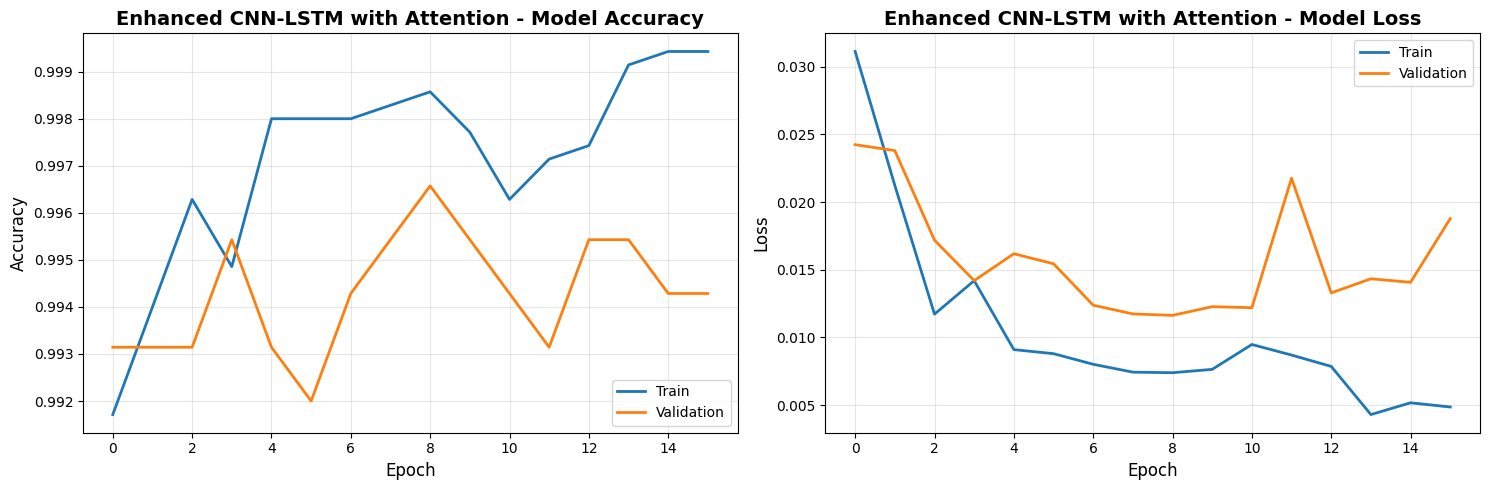

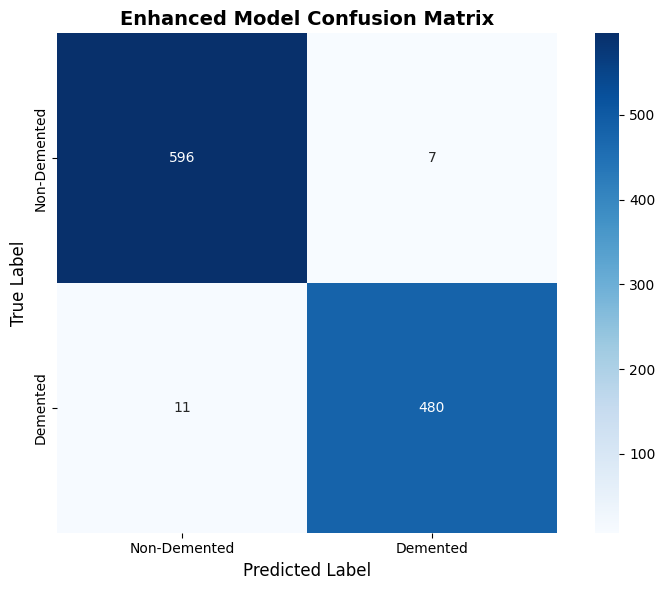

In [16]:
plot_training_history(
    history,
    "Enhanced CNN-LSTM with Attention",
    CONFIG["results_path"] / "training_curves" / "enhanced_model_training.png"
)

plot_confusion_matrix(
    metrics["confusion_matrix"],
    CONFIG["class_names"],
    "Enhanced Model Confusion Matrix",
    CONFIG["results_path"] / "confusion_matrices" / "enhanced_model_cm.png"
)

## 7. Save Results

In [17]:
# Save final model
torch.save(model.state_dict(), CONFIG["saved_models_path"] / "enhanced_cnn_lstm_final.pth")

# Save results
results = {
    "model_name": "Enhanced-CNN-LSTM-with-Attention",
    "accuracy": float(metrics["accuracy"]),
    "precision": float(metrics["precision"]),
    "recall": float(metrics["recall"]),
    "f1_score": float(metrics["f1_score"]),
    "specificity": float(metrics["specificity"]),
    "auc": float(metrics.get("auc", 0)),
    "training_time_seconds": float(training_time),
    "testing_time_ms": float(testing_time),
    "architecture_features": [
        "Spatial Attention",
        "Channel Attention (SE-Blocks)",
        "Residual Connections",
        "Batch Normalization",
        "LSTM Temporal Modeling"
    ]
}

with open(CONFIG["results_path"] / "enhanced_model_results.json", "w") as f:
    json.dump(results, f, indent=2)

print("\n✓ Enhanced model trained and saved successfully!")
print(f"✓ Results saved to: enhanced_model_results.json")
print(f"\nNovel Architecture Features:")
for feature in results["architecture_features"]:
    print(f"  ✓ {feature}")


✓ Enhanced model trained and saved successfully!
✓ Results saved to: enhanced_model_results.json

Novel Architecture Features:
  ✓ Spatial Attention
  ✓ Channel Attention (SE-Blocks)
  ✓ Residual Connections
  ✓ Batch Normalization
  ✓ LSTM Temporal Modeling
